<a href="https://colab.research.google.com/github/manuflores/grn_learn/blob/master/vae_191117.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm

from keras import backend as K
from keras.layers import Input, Dense, Lambda, Layer, Add, Multiply
from keras.models import Model, Sequential
from keras.datasets import mnist


#%matplotlib inline
# This enables high res graphics inline
#%config InlineBackend.figure_format = 'svg'

original_dim = 784
intermediate_dim = 256
latent_dim = 2
batch_size = 1000
epochs = 50
epsilon_std = 1.0


def nll(y_true, y_pred):
    """ Negative log likelihood (Bernoulli). """

    # keras.losses.binary_crossentropy gives the mean
    # over the last axis. we require the sum
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

class KLDivergenceLayer(Layer):

    """ Identity transform layer that adds KL divergence
    to the final model loss.
    """

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs



In [0]:
epochs = 10

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 30us/step - loss: 264.2224 - val_loss: 210.0376
Epoch 2/10
60000/60000 [==============================] - 1s 20us/step - loss: 199.7525 - val_loss: 189.6338
Epoch 3/10
60000/60000 [==============================] - 1s 20us/step - loss: 186.8382 - val_loss: 182.2562
Epoch 4/10
60000/60000 [==============================] - 1s 20us/step - loss: 181.1232 - val_loss: 178.0188
Epoch 5/10
60000/60000 [==============================] - 1s 20us/step - loss: 177.2652 - val_loss: 175.0306
Epoch 6/10
60000/60000 [==============================] - 1s 20us/step - loss: 174.5280 - val_loss: 173.0556
Epoch 7/10
60000/60000 [==============================] - 1s 20us/step - loss: 172.7552 - val_loss: 171.7415
Epoch 8/10
60000/60000 [==============================] - 1s 20us/step - loss: 171.4704 - val_loss: 171.1133
Epoch 9/10
60000/60000 [==============================] - 1s 20us/step - loss:

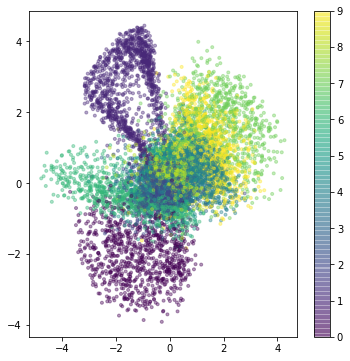

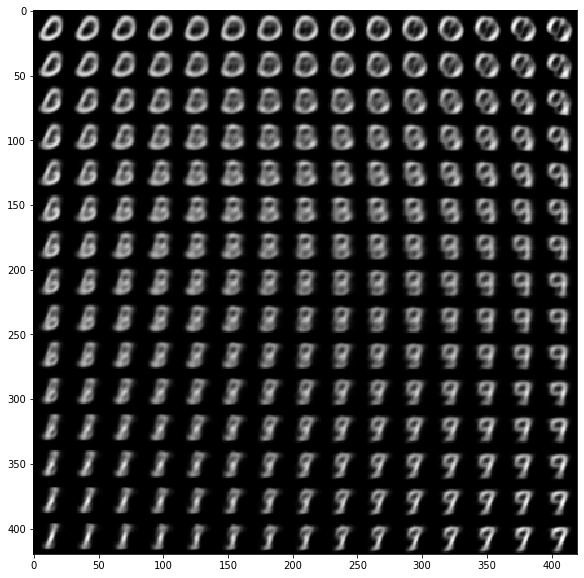

In [0]:

decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

eps = Input(tensor=K.random_normal(stddev=epsilon_std,
                                   shape=(K.shape(x)[0], latent_dim)))
z_eps = Multiply()([z_sigma, eps])
z = Add()([z_mu, z_eps])

x_pred = decoder(z)

vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll)

# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.

vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian
u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n),
                               np.linspace(0.05, 0.95, n)))


z_grid = norm.ppf(u_grid)

x_decoded = decoder.predict(z_grid.reshape(n*n, latent_dim))
x_decoded = x_decoded.reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_decoded))), cmap='gray')
plt.show()